<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/3.6%20Distance%20Estimation%20Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns

     |████████████████████████████████| 3.1MB 14.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 164kB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
     |████████████████████████████████| 1.6MB 43.1MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 3.2MB 44.5MB/s 


In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1, mass2, resolution, frequencybound, distance, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Taken from notebook 3.2 (SNR expectation value without any noise)

def expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Create distance estimation function

def estimate_distance(snr, guess, alpha, iterations, mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18, progress='yes'): 
  
  if distance == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
    print("Initial guess: {}".format(estimate))

    for i in range(iterations):
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
      if progress == 'yes':
        print("Iteration {}: SNR = {}, Distance = {}".format(i, estimate, pred))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred, diff) 

In [ ]:
## Determine expectation distance at different masses

masslist = np.arange(20, 100, 1)
distlist6 = [0] * len(masslist)
distlist8 = [0] * len(masslist)
distlist10 = [0] * len(masslist)

difflist6 = [0] * len(masslist)
difflist8 = [0] * len(masslist)
difflist10 = [0] * len(masslist)

distlist = [distlist6, distlist8, distlist10]
difflist = [difflist6, difflist8, difflist10]
snrlist = [6, 8, 10]

for i in range(len(masslist)):
  alpha = -50
  print("Mass: {}".format(masslist[i]))
  for j in range(len(snrlist)):
      distlist[j][i], difflist[j][i] = estimate_distance(snr=snrlist[j], guess=4000, alpha=alpha, iterations=80,
                                  mass1=masslist[i], mass2=masslist[i], templatemass1=masslist[i], templatemass2=masslist[i],
                                  resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance='param')
 
                                  

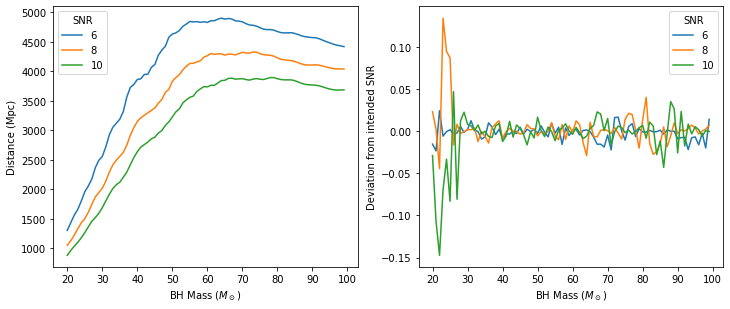

In [ ]:
fig = plt.figure(figsize=(12, 4.8))

plt.subplot(1,2,1)
for i in range(len(distlist)):
  pylab.plot(masslist, distlist[i])

pylab.xlabel("BH Mass ($M_\odot$)")
pylab.ylabel("Distance (Mpc)")
pylab.legend(labels=[6, 8, 10], title="SNR")

plt.subplot(1,2,2)
for i in range(len(difflist)):
  pylab.plot(masslist, difflist[i])

pylab.xlabel("BH Mass ($M_\odot$)")
pylab.ylabel("Deviation from intended SNR")
pylab.legend(labels=[6,8,10], title="SNR")

In [ ]:
## Determine reason for deviation in gradient descent

dist = np.arange(3000, 3050, 0.05)
snr = [0] * len(dist)

for i in range(len(dist)):
  snr[i] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30,
                           resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20,
                           distance=dist[i], psd='aLIGODesignSensitivityP1200087')

Text(0, 0.5, 'Signal-to-Noise Ratio')

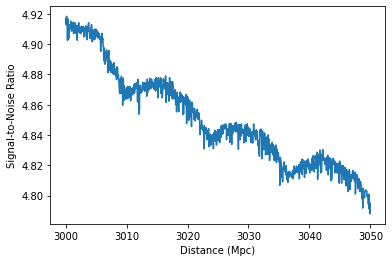

In [ ]:
pylab.plot(dist, snr)
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")

In [ ]:
## Plot expectation SNR 

dist = np.arange(1000, 12000, 5)
snr30 = [0] * len(dist)

for i in range(len(dist)):
  snr30[i] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30,
                           resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10,
                           distance=dist[i], psd='CosmicExplorerP1600143')

  print("Distance: {}".format(dist[i]))  


In [ ]:
snr50 = [0] * len(dist)

for i in range(len(dist)):
  snr50[i] = expectation_SNR(mass1=50, mass2=50, templatemass1=50, templatemass2=50,
                             resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10,
                             distance=dist[i], psd='CosmicExplorerP1600143')
  
  print("Distance: {}".format(dist[i])) 

In [ ]:
snr70 = [0] * len(dist)

for i in range(len(dist)):
  snr70[i] = expectation_SNR(mass1=70, mass2=70, templatemass1=70, templatemass2=70,
                           resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10,
                           distance=dist[i], psd='CosmicExplorerP1600143')

  print("Distance: {}".format(dist[i]))   

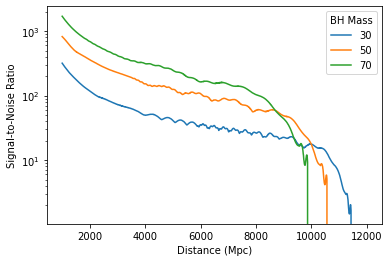

In [ ]:
pylab.plot(dist, snr30)
pylab.plot(dist, snr50)
pylab.plot(dist, snr70)
pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-Noise Ratio")
pylab.yscale('log')
pylab.legend(labels=[30, 50, 70], title="BH Mass")

In [ ]:
## Determine distance measurements for different sensitivities

masslist = np.arange(25, 75, 1)
distlist6aligo, distlist8aligo, distlist10aligo, distlist6aplus, distlist8aplus, distlist10aplus, distlist6cosmic, distlist8cosmic, distlist10cosmic = ([0] * len(masslist) for i in range(9))
difflist6aligo, difflist8aligo, difflist10aligo, difflist6aplus, difflist8aplus, difflist10aplus, difflist6cosmic, difflist8cosmic, difflist10cosmic = ([0] * len(masslist) for i in range(9))

distlistaligo = [distlist6aligo, distlist8aligo, distlist10aligo]
distlistaplus = [distlist6aplus, distlist8aplus, distlist10aplus]
distlistcosmic = [distlist6cosmic, distlist8cosmic, distlist10cosmic]
distlist = [distlistaligo, distlistaplus, distlistcosmic]
psdlist = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

difflistaligo = [difflist6aligo, difflist8aligo, difflist10aligo]
difflistaplus = [difflist6aplus, difflist8aplus, difflist10aplus]
difflistcosmic = [difflist6cosmic, difflist8cosmic, difflist10cosmic]
difflist = [difflistaligo, difflistaplus, difflistcosmic]

snrlist=[6,8,10]
lowfreq=[20,20,10]
guess=[2500, 3000, 10750]
alpha=[-80, -80, -30]
iterations=[30, 30, 80]

for psd in range(len(distlist)):
  for snr in range(len(distlistaligo)):
    for mass in range(len(masslist)):

      distlist[psd][snr][mass], difflist[psd][snr][mass] = estimate_distance(snr=snrlist[snr], guess=guess[psd], alpha=alpha[snr], iterations=iterations[psd], progress='no',
                                  mass1=masslist[mass], mass2=masslist[mass], templatemass1=masslist[mass], templatemass2=masslist[mass],
                                  resolution=1.0/1024, psdresolution=1.0/16, lowfreq=lowfreq[psd], psd = psdlist[psd], distance='param')
      
      print("Mass: {}, PSD: {}, SNR: {}".format(masslist[mass], psdlist[psd], snrlist[snr]))
    

    

In [ ]:
## Finish calculating distances for Cosmic Explorer
masslist = np.arange(25, 75, 1)

distlist8cosmic = [0] * len(masslist)
difflist8cosmic = [0] * len(masslist)

for mass in range(len(masslist)): 
  distlist8cosmic[mass], difflist8cosmic[mass] = estimate_distance(snr=8, guess=11000-20*mass, alpha=-20, iterations=100, progress='yes',
                                                       mass1=masslist[mass], mass2=masslist[mass], templatemass1=masslist[mass], templatemass2=masslist[mass],
                                                       resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10, psd='CosmicExplorerP1600143', distance='param')

In [ ]:
masslist = np.arange(25, 75, 1)

distlist10cosmic = [0] * len(masslist)
difflist10cosmic = [0] * len(masslist)

for mass in range(len(masslist)): 
  distlist10cosmic[mass], difflist10cosmic[mass] = estimate_distance(snr=10, guess=11000-20*mass, alpha=-50, iterations=50, progress='no',
                                                       mass1=masslist[mass], mass2=masslist[mass], templatemass1=masslist[mass], templatemass2=masslist[mass],
                                                       resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10, psd='CosmicExplorerP1600143', distance='param')

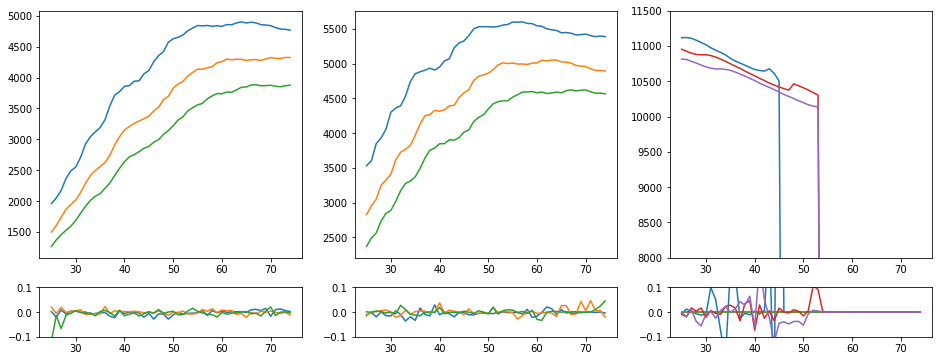

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16,6), gridspec_kw={'height_ratios': [5, 1]})

for i in range(len(distlist)):
  for j in range(len(distlist[i])):
    axs[0, i].plot(masslist, distlist[i][j])

for i in range(len(difflist)): 
  for j in range(len(difflist[i])):
    axs[1, i].plot(masslist, difflist[i][j])

axs[0,2].plot(masslist, distlist8cosmic)
axs[1,2].plot(masslist, difflist8cosmic)

axs[0,2].plot(masslist, distlist10cosmic)
axs[1,2].plot(masslist, difflist10cosmic)

axs[0,2].set_ylim([8000, 11500])
for i in range(len(difflist)):
  axs[1,i].set_ylim([-0.1, 0.1])

## Distance shows 0 when estimate_distance hits an error

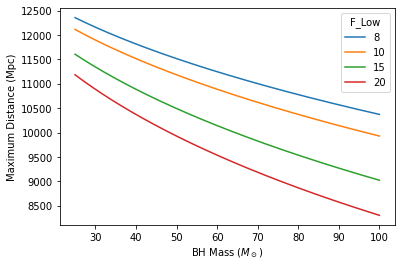

In [ ]:
## Plot maximum redshift and distance as a function of mass 

mass = np.arange(25, 100, 0.01)
period = [0] * len(mass)

redshift8, redshift10, redshift15, redshift20 = ([0] * len(mass) for i in range(4))
redshift = [redshift8, redshift10, redshift15, redshift20]

distance8, distance10, distance15, distance20 = ([0] * len(mass) for i in range(4))
distance = [distance8, distance10, distance15, distance20]

lowfreq = [8, 10, 15, 20]
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.310)

for i in range(len(mass)): 
  period[i] = np.sqrt(32) * np.pi * (6.67408 * 10**-11) * mass[i] * (1.989 * 10**30) / 299792458**3
  for j in range(len(lowfreq)): 
    redshift[j][i] = (1 / lowfreq[j]) / period[i]
    distance[j][i] = cosmo.comoving_distance(redshift[j][i]).value

for j in range(lent(lowfreq)):
  pylab.plot(mass, distance[j])

pylab.xlabel("BH Mass ($M_\odot$)")
pylab.ylabel("Maximum Distance (Mpc)")
pylab.legend(labels=lowfreq, title="F_Low")